Sentiment Analysis of the book

In [1]:
import nltk
#nltk.download("gutenberg")
#import gutenberg
import numpy as np
import re

import os, pathlib, glob #these packages allow us to navigate through the files on our own computers
from pathlib import Path #the pathlib package helps us work with file paths
#for more on using pathlib see: https://builtin.com/software-engineering-perspectives/python-pathlib
import collections

import pandas as pd #for creating and working with dataframes
import nltk, re #we can import multiple packages on one line using commas to separate new package names
from nltk import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk import ngrams, pos_tag, word_tokenize, sent_tokenize
nltk.download('punkt')

#matplotlib and seaborn are used here to create graphs, charts, and other visualizations
import matplotlib.pyplot as plt #needed for xticks
import seaborn as sns

#code below modifies how plots will be shown in this notebook
plt.rcParams['figure.figsize'] = [12, 8]  #changes default figure size to make larger plots
%config InteractiveShellApp.matplotlib = 'inline'
%config InlineBackend.figure_formats = ['svg']

#Press CTRL+Enter to run this codeblock!

from ast import literal_eval

nltk.download('punkt')         #nltk - here we need to download and import specific packages from nltk
from nltk import word_tokenize
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer

from nltk.stem import WordNetLemmatizer
nltk_lemmatizer = WordNetLemmatizer()

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pranaypk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pranaypk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import spacy
from spacy.lang.en.examples import sentences
from spacy import displacy 

nlp = spacy.load('en_core_web_sm')

In [3]:
#importing pride and prejudice txt file from project gutenberg
import requests
raw = requests.get('https://www.gutenberg.org/cache/epub/1342/pg1342.txt').text
#print(raw)
print("total length of the book is: ", len(raw))

total length of the book is:  762984


In [4]:
#to remove the project gutenberg's promt at the start and end of the book using regex
beg_regex = '\*\*\*\s?START OF THE PROJECT GUTENBERG EBOOK PRIDE AND PREJUDICE *\*\*' #sentance that is usually at the start
draft_beg_position = re.search(beg_regex, raw)
begin = draft_beg_position.end() #we find the end of the regex so we can take the text beginning from it
#print(begin)

end_regex = 'end of th(is|e) project gutenberg ebook'
end_position = re.search(end_regex, raw.lower())
end = end_position.start() #we find the start of the regex so we can take the text until it's start
#print(end)

#we finally take the text in between those 2 sentances to remove the prompts at the start and end

text = raw[begin:end].lower()

In [5]:
# I am diving the novel into 40 parts so that we can track the emotions and people as the book progresses

#this function is to clean i.e. remove any \n's or \r's in the text

def clean_text(text):
    # Remove leading/trailing whitespaces and line breaks
    cleaned_text = text.strip()
    # Remove any remaining carriage return (\r) and newline (\n) characters
    cleaned_text = cleaned_text.replace("\r", "").replace("\n", "")
    return cleaned_text

#this function is to divide the text into any number of parts

def divide_text_into_equal_parts(text, num_parts):
    # Clean the text
    cleaned_text = clean_text(text)

    # Calculate the size of each part
    part_size = len(cleaned_text) // num_parts

    # Split the text into equal parts
    parts = [cleaned_text[i * part_size:(i + 1) * part_size] for i in range(num_parts)]

    return parts

chapters = divide_text_into_equal_parts(text, 200)

for i in range(len(chapters)):
    chapters[i] = tokenizer.tokenize(chapters[i])
print(len(chapters))

200


In [6]:
# I am making a data frame with the 40 parts of texts that we divided
final_df = pd.DataFrame({'chapters': chapters})

In [7]:
#removing all the stop words from the "chapters" column
stop = stopwords.words('english')
stop = sorted(stop)

#going thorough each row and removing stop words
final_df['chapters'] = final_df['chapters'].apply(lambda x: [i for i in x if i not in stop])


# making another column that counts all the tokens in the "chapters" column
final_df['token_freq'] = final_df['chapters'].apply(lambda x: collections.Counter(x))

final_df.head()

,chapters,token_freq
0,"[illustration, george, allen, publisher, 156, ...","{'illustration': 5, 'george': 3, 'allen': 2, '..."
1,"[author, time, composition, seen, rathermore, ...","{'author': 2, 'time': 1, 'composition': 1, 'se..."
2,"[ted, told, puppets, pebbles, mouths, despite,...","{'ted': 1, 'told': 1, 'puppets': 1, 'pebbles':..."
3,"[playing, setting, atwork, fools, mean, person...","{'playing': 1, 'setting': 1, 'atwork': 1, 'foo..."
4,"[lity, appears, present, novel, appearsnowhere...","{'lity': 1, 'appears': 1, 'present': 1, 'novel..."


In [8]:
#column for the whole chapter text so that we can use spacy for named entity recognition
final_df['full_text'] = None
#column to get the entity type using ner
final_df['ent_type'] = None
#filter only people from the entity type
final_df['only_people'] = None
#find the frequency of each person using the only people column
final_df['person_freq'] = None

#define columns for words, frequecy of words and the total number of tokens after lemmatization
final_df['lemmas'] = None
final_df['lemmas_freq'] = None
final_df['total_tokens'] = None

for i in range(len(final_df['chapters'])):
    final_df['full_text'][i] = " ".join(final_df['chapters'][i]) #join all the strings in the list to make a full text
    ner = nlp(final_df['full_text'][i])
    ents = [(e.text, e.label_) for e in ner.ents]
    final_df['ent_type'][i] = ents # find entity type for each token
    
    #filter only the entity type: people from the ent_type column and make a new column - only_people
    l = final_df['ent_type'][i]
    new_l = []
    for t in l:
        if t[1] == "PERSON":
            new_l.append(t)
    final_df['only_people'][i] = new_l
    
    #find the frequency of each person using the only_people column
    p_freq = collections.Counter(final_df['only_people'][i])
    p_freq = p_freq.most_common(10)
    final_df['person_freq'][i] = p_freq
    
    # lemmatize the words to it's unit form
    o = final_df['chapters'][i]
    row_list = []
    for j in o:
        row_list.append(nltk_lemmatizer.lemmatize(j))
    final_df['lemmas'][i] = row_list
    final_df['total_tokens'][i] = len(row_list)
    
#find the frequency of the words after lemmatization
final_df['lemmas_freq'] = final_df['lemmas'].apply(lambda x: collections.Counter(x))

#reviewing the data frame now
final_df.head()

,chapters,token_freq,full_text,ent_type,only_people,person_freq,lemmas,lemmas_freq,total_tokens
0,"[illustration, george, allen, publisher, 156, ...","{'illustration': 5, 'george': 3, 'allen': 2, '...",illustration george allen publisher 156 charin...,"[(george allen, PERSON), (156 charing, MONEY),...","[(george allen, PERSON), (george saintsbury, P...","[((hugh thomson, PERSON), 2), ((george allen, ...","[illustration, george, allen, publisher, 156, ...","{'illustration': 7, 'george': 3, 'allen': 2, '...",242
1,"[author, time, composition, seen, rathermore, ...","{'author': 2, 'time': 1, 'composition': 1, 'se...",author time composition seen rathermore world ...,"[(bates, PERSON), (first, ORDINAL), (first, OR...","[(bates, PERSON), (crawford mrs rushworth, PER...","[((bates, PERSON), 1), ((crawford mrs rushwort...","[author, time, composition, seen, rathermore, ...","{'author': 2, 'time': 1, 'composition': 1, 'se...",299
2,"[ted, told, puppets, pebbles, mouths, despite,...","{'ted': 1, 'told': 1, 'puppets': 1, 'pebbles':...",ted told puppets pebbles mouths despite theabi...,"[(johnthorpe eltons, PERSON), (one two, CARDIN...","[(johnthorpe eltons, PERSON), (induce playat, ...","[((johnthorpe eltons, PERSON), 1), ((induce pl...","[ted, told, puppet, pebble, mouth, despite, th...","{'ted': 1, 'told': 1, 'puppet': 1, 'pebble': 1...",311
3,"[playing, setting, atwork, fools, mean, person...","{'playing': 1, 'setting': 1, 'atwork': 1, 'foo...",playing setting atwork fools mean persons thin...,"[(smith truly, ORG), (two, CARDINAL), (one thr...","[(elizabeth mrs bennet, PERSON), (mrs bennet, ...","[((elizabeth mrs bennet, PERSON), 1), ((mrs be...","[playing, setting, atwork, fool, mean, person,...","{'playing': 1, 'setting': 1, 'atwork': 1, 'foo...",326
4,"[lity, appears, present, novel, appearsnowhere...","{'lity': 1, 'appears': 1, 'present': 1, 'novel...",lity appears present novel appearsnowhere else...,"[(one, CARDINAL), (first, ORDINAL), (second, O...","[(john dashwood, PERSON), (earl daughter ladyp...","[((john dashwood, PERSON), 1), ((earl daughter...","[lity, appears, present, novel, appearsnowhere...","{'lity': 1, 'appears': 1, 'present': 1, 'novel...",304


In [9]:
#these were the functions that were provided in the class to find the emotion score using the NRC lexicon. 
#I will use these to find the emotional score of each chapter in the data frame

def emo_score(lemma, freq, emolex_words):
    '''
    INPUT: lemmatized, lower-cased word (lemma) + frequency this lemma appears in a text
    OUTPUT: list of 10 NRC emotions scores (8 emotions + 2 sentiments [positive / negative])

    reads in a lemmatized word, looks it up in NRC lexicon dictionary (emolex_words) and returns the score of the word
    for the 8 emotions and 2 sentiments in the lexicon

    then takes the resulting list of 10 scores and multiples each by the frequency of the word
    returning the new list

    '''
    if (emolex_words[ 'word'].eq(lemma)).any():   #if any word in the "word" column in emolex_words equals the inputted lemma:
        #print(lemma)
        emolex_row = emolex_words[emolex_words['word'] == lemma].loc[:,'anger':'trust']
        #print(emolex_row)
        emolex_list = [item for item in emolex_row.iloc[0]]
        new_emo_scores = [item * freq for item in emolex_list]
        #print(new_emo_scores, "\n")
        #emo_scores = [x + y for x,y in zip(emo_scores, new_emo_scores)]
        return(new_emo_scores)
    else:                                          #else: lemma not in emolex_words dataframe
        return(None)

def emo_score_by_text (lemmadict, emolex_words):
    '''
    INPUT: reads in a frequency dictionary of lemmatized words (lemmadict)
    OUTPUT: returns a list of 10 cumulative scores for each of the 8 emotions and 2 sentiments in the NRC lexicon


    '''
    cum_emo_score = [0,0,0,0,0,0,0,0,0,0]
    for key, val in lemmadict.items():
        temp_emo_score = emo_score(key, val, emolex_words)
        if temp_emo_score is not None:
            cum_emo_score = [x + y for x, y in zip(cum_emo_score, temp_emo_score)]
    return(cum_emo_score)

def corpus_emo_scores(df, freq_lemmas_col):
    '''
    INPUT: a dataframe of texts (df), with a column name (freq_lemmas_col) indicating a column
    with a frequency dictionary of lemmatized words for each text
    OUTPUT: returns df with a new column recording the total 10 NRC scores for each text
    '''     
    new_df = df.copy()
    filepath = Path('NRC-Emotion-Lexicon','NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    #print(emolex_words)
    #print(new_df[freq_lemmas_col])
    #emotions = emolex_words.columns.drop('word')
    #emo_df = pd.DataFrame(0, index = sotudf.index, columns = emotions)    ## Let's replace that with the name of our dataframe ("sotudf")

    #new_df['emo_score'] = new_df[freq_lemmas_col].apply(emo_score_by_text)
    new_df['emo_score'] = new_df.apply(lambda x: emo_score_by_text(x[freq_lemmas_col], emolex_words), axis = 1)
    return(new_df)



In [10]:
#calling the corpus_emo_scores function by giving my final_df and lemmas freqency dictionary columms
results_df = corpus_emo_scores(final_df, "lemmas_freq")  
#results after finding the emotion scores
results_df.head()

,chapters,token_freq,full_text,ent_type,only_people,person_freq,lemmas,lemmas_freq,total_tokens,emo_score
0,"[illustration, george, allen, publisher, 156, ...","{'illustration': 5, 'george': 3, 'allen': 2, '...",illustration george allen publisher 156 charin...,"[(george allen, PERSON), (156 charing, MONEY),...","[(george allen, PERSON), (george saintsbury, P...","[((hugh thomson, PERSON), 2), ((george allen, ...","[illustration, george, allen, publisher, 156, ...","{'illustration': 7, 'george': 3, 'allen': 2, '...",242,"[7, 6, 4, 8, 13, 13, 32, 7, 4, 19]"
1,"[author, time, composition, seen, rathermore, ...","{'author': 2, 'time': 1, 'composition': 1, 'se...",author time composition seen rathermore world ...,"[(bates, PERSON), (first, ORDINAL), (first, OR...","[(bates, PERSON), (crawford mrs rushworth, PER...","[((bates, PERSON), 1), ((crawford mrs rushwort...","[author, time, composition, seen, rathermore, ...","{'author': 2, 'time': 1, 'composition': 1, 'se...",299,"[8, 15, 4, 5, 15, 14, 32, 7, 8, 17]"
2,"[ted, told, puppets, pebbles, mouths, despite,...","{'ted': 1, 'told': 1, 'puppets': 1, 'pebbles':...",ted told puppets pebbles mouths despite theabi...,"[(johnthorpe eltons, PERSON), (one two, CARDIN...","[(johnthorpe eltons, PERSON), (induce playat, ...","[((johnthorpe eltons, PERSON), 1), ((induce pl...","[ted, told, puppet, pebble, mouth, despite, th...","{'ted': 1, 'told': 1, 'puppet': 1, 'pebble': 1...",311,"[8, 9, 7, 10, 10, 18, 28, 6, 3, 11]"
3,"[playing, setting, atwork, fools, mean, person...","{'playing': 1, 'setting': 1, 'atwork': 1, 'foo...",playing setting atwork fools mean persons thin...,"[(smith truly, ORG), (two, CARDINAL), (one thr...","[(elizabeth mrs bennet, PERSON), (mrs bennet, ...","[((elizabeth mrs bennet, PERSON), 1), ((mrs be...","[playing, setting, atwork, fool, mean, person,...","{'playing': 1, 'setting': 1, 'atwork': 1, 'foo...",326,"[4, 18, 3, 13, 20, 19, 45, 16, 13, 20]"
4,"[lity, appears, present, novel, appearsnowhere...","{'lity': 1, 'appears': 1, 'present': 1, 'novel...",lity appears present novel appearsnowhere else...,"[(one, CARDINAL), (first, ORDINAL), (second, O...","[(john dashwood, PERSON), (earl daughter ladyp...","[((john dashwood, PERSON), 1), ((earl daughter...","[lity, appears, present, novel, appearsnowhere...","{'lity': 1, 'appears': 1, 'present': 1, 'novel...",304,"[3, 13, 6, 5, 18, 17, 43, 6, 8, 24]"


In [11]:
#splitting the emo score column into each emotion
results_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']] = pd.DataFrame(results_df.emo_score.tolist(), index = results_df.index)
results_df = results_df.drop(columns = ['emo_score'])

#selecting the important columns
final_results = results_df[['full_text', 'person_freq', 'lemmas', 'lemmas_freq','total_tokens', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
final_results.head()

,full_text,person_freq,lemmas,lemmas_freq,total_tokens,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,illustration george allen publisher 156 charin...,"[((hugh thomson, PERSON), 2), ((george allen, ...","[illustration, george, allen, publisher, 156, ...","{'illustration': 7, 'george': 3, 'allen': 2, '...",242,7,6,4,8,13,13,32,7,4,19
1,author time composition seen rathermore world ...,"[((bates, PERSON), 1), ((crawford mrs rushwort...","[author, time, composition, seen, rathermore, ...","{'author': 2, 'time': 1, 'composition': 1, 'se...",299,8,15,4,5,15,14,32,7,8,17
2,ted told puppets pebbles mouths despite theabi...,"[((johnthorpe eltons, PERSON), 1), ((induce pl...","[ted, told, puppet, pebble, mouth, despite, th...","{'ted': 1, 'told': 1, 'puppet': 1, 'pebble': 1...",311,8,9,7,10,10,18,28,6,3,11
3,playing setting atwork fools mean persons thin...,"[((elizabeth mrs bennet, PERSON), 1), ((mrs be...","[playing, setting, atwork, fool, mean, person,...","{'playing': 1, 'setting': 1, 'atwork': 1, 'foo...",326,4,18,3,13,20,19,45,16,13,20
4,lity appears present novel appearsnowhere else...,"[((john dashwood, PERSON), 1), ((earl daughter...","[lity, appears, present, novel, appearsnowhere...","{'lity': 1, 'appears': 1, 'present': 1, 'novel...",304,3,13,6,5,18,17,43,6,8,24


In [12]:
#taking the proportion of emotion words to the total number of word tokens
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for emotion in emotions:
    final_results[emotion] = final_results[emotion] / final_results['total_tokens']
final_results.head()

C:\Users\pranaypk\AppData\Local\Temp\ipykernel_22936\3000396477.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_results[emotion] = final_results[emotion] / final_results['total_tokens']


,full_text,person_freq,lemmas,lemmas_freq,total_tokens,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,illustration george allen publisher 156 charin...,"[((hugh thomson, PERSON), 2), ((george allen, ...","[illustration, george, allen, publisher, 156, ...","{'illustration': 7, 'george': 3, 'allen': 2, '...",242,0.028926,0.024793,0.016529,0.033058,0.053719,0.053719,0.132231,0.028926,0.016529,0.078512
1,author time composition seen rathermore world ...,"[((bates, PERSON), 1), ((crawford mrs rushwort...","[author, time, composition, seen, rathermore, ...","{'author': 2, 'time': 1, 'composition': 1, 'se...",299,0.026756,0.050167,0.013378,0.016722,0.050167,0.046823,0.107023,0.023411,0.026756,0.056856
2,ted told puppets pebbles mouths despite theabi...,"[((johnthorpe eltons, PERSON), 1), ((induce pl...","[ted, told, puppet, pebble, mouth, despite, th...","{'ted': 1, 'told': 1, 'puppet': 1, 'pebble': 1...",311,0.025723,0.028939,0.022508,0.032154,0.032154,0.057878,0.090032,0.019293,0.009646,0.03537
3,playing setting atwork fools mean persons thin...,"[((elizabeth mrs bennet, PERSON), 1), ((mrs be...","[playing, setting, atwork, fool, mean, person,...","{'playing': 1, 'setting': 1, 'atwork': 1, 'foo...",326,0.01227,0.055215,0.009202,0.039877,0.06135,0.058282,0.138037,0.04908,0.039877,0.06135
4,lity appears present novel appearsnowhere else...,"[((john dashwood, PERSON), 1), ((earl daughter...","[lity, appears, present, novel, appearsnowhere...","{'lity': 1, 'appears': 1, 'present': 1, 'novel...",304,0.009868,0.042763,0.019737,0.016447,0.059211,0.055921,0.141447,0.019737,0.026316,0.078947


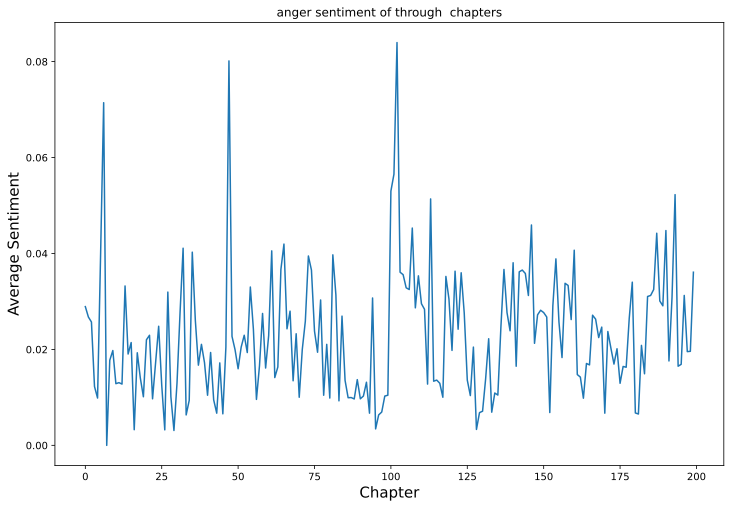

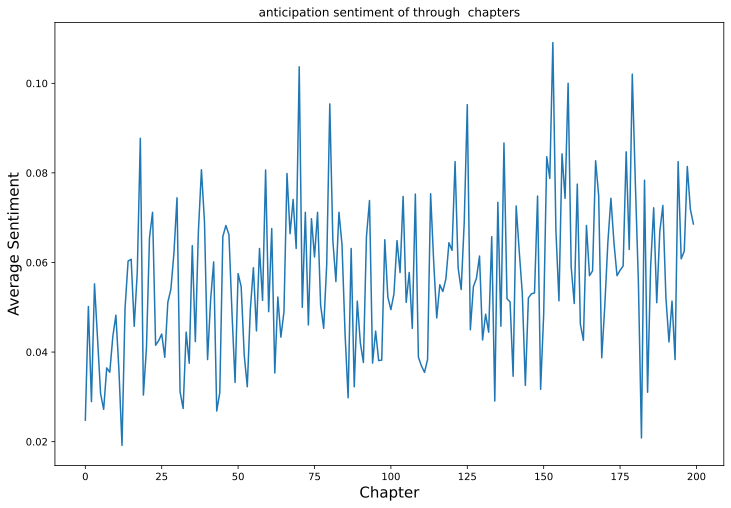

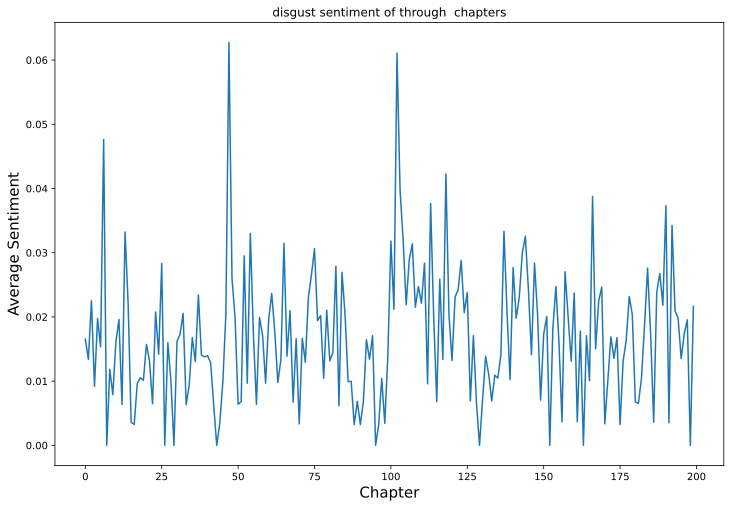

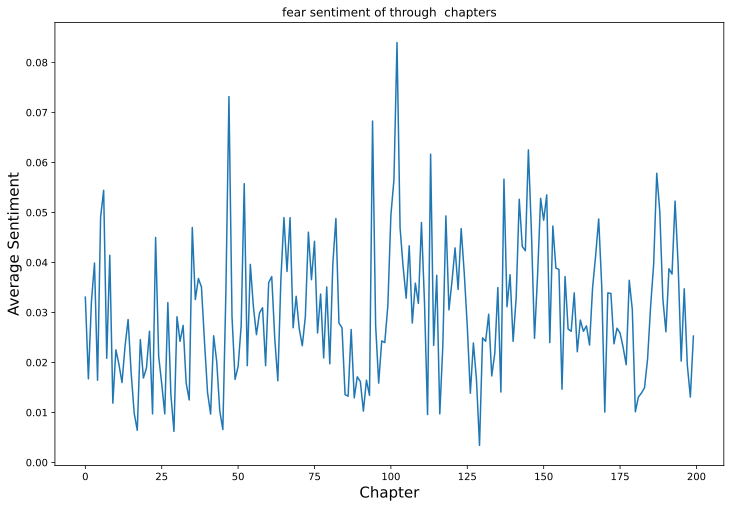

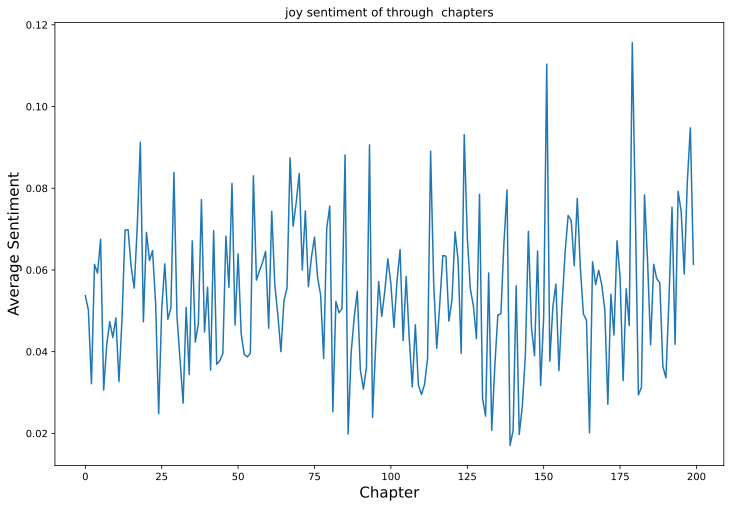

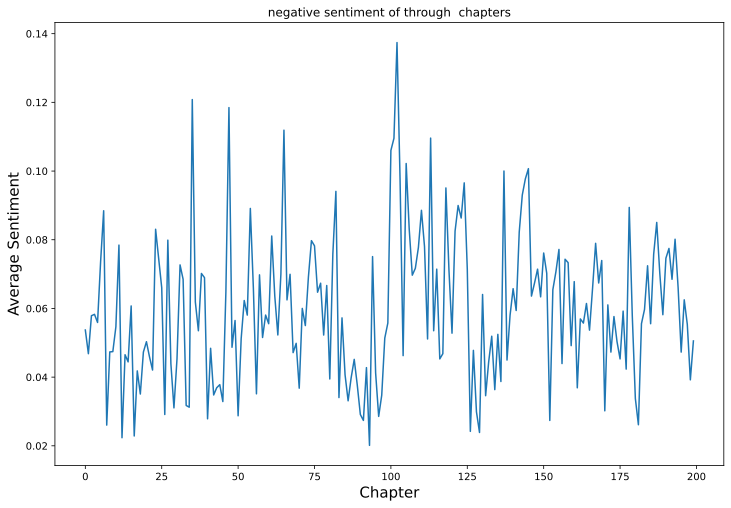

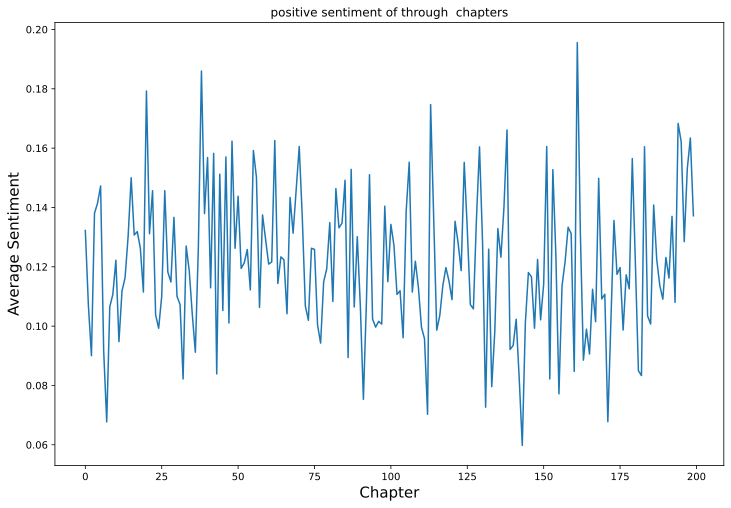

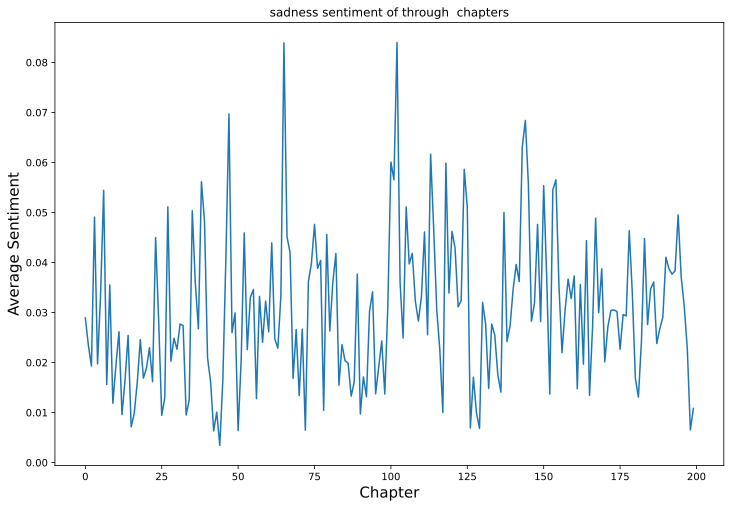

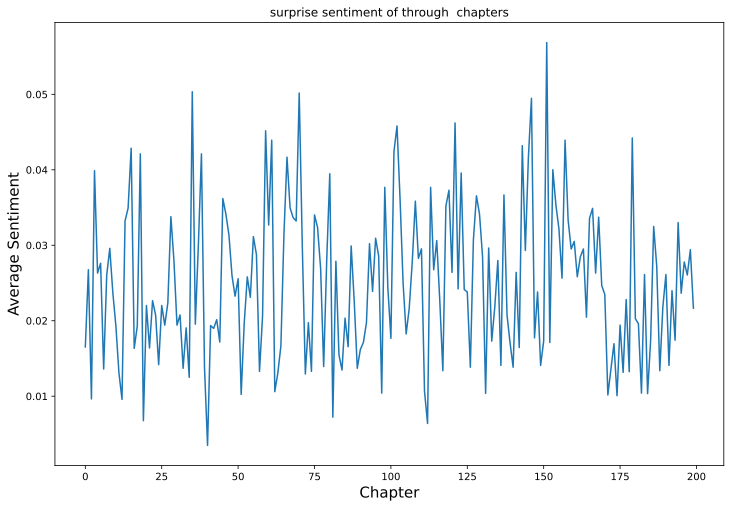

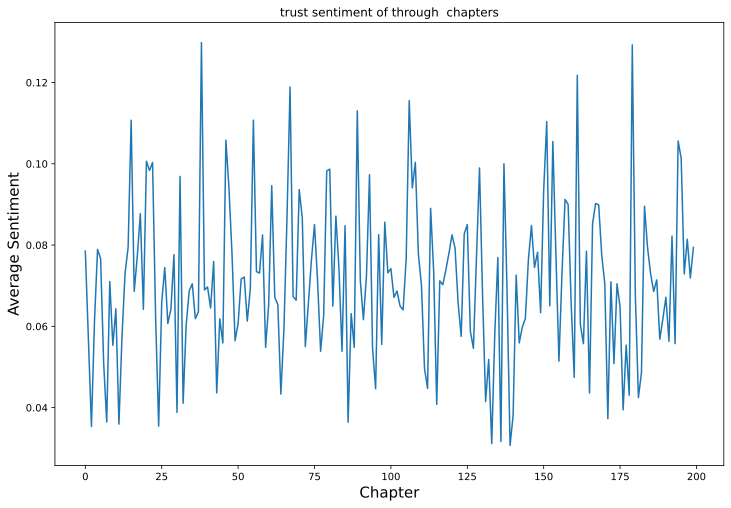

In [13]:

#Graphs of the changes in all emotions through the chapters
x = list(range(0,len(final_results)))
for emotion in emotions:
    y = final_results[emotion]
    plt.plot(x,y)
    plt.title('{} sentiment of through  chapters'.format(emotion, fontsize=24))
    plt.xlabel('Chapter', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    #plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.05, 1))
    plt.show()

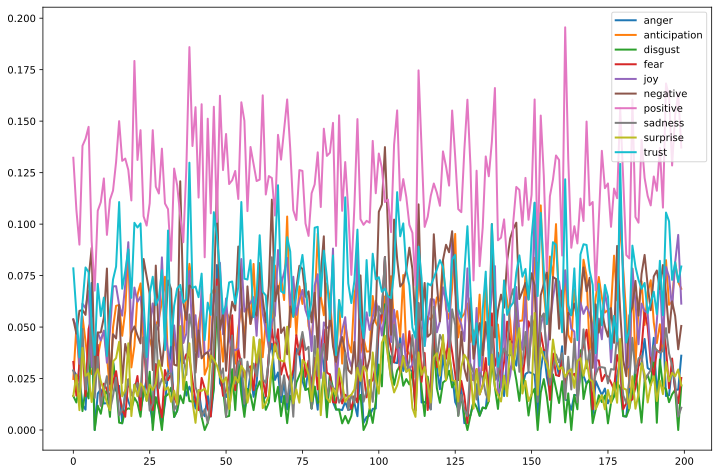

In [14]:
#we can also look at all the emotions in one graph to compare themm

x = list(range(0,len(final_results)))
for emotion in emotions:
        plt.plot(x, final_results[emotion],linewidth=2, label =emotion)
plt.legend()

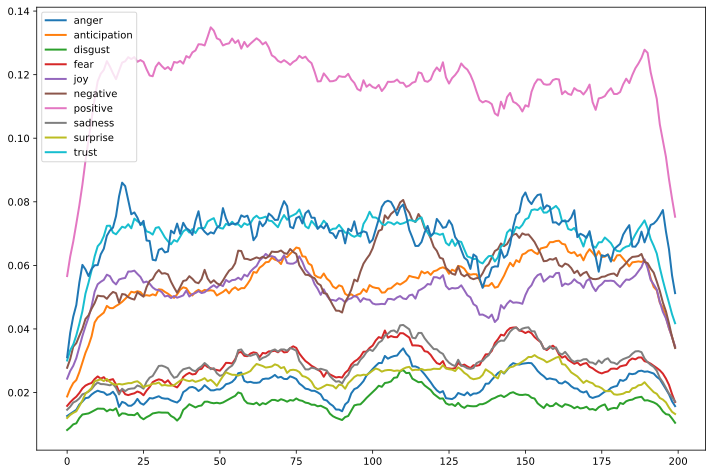

In [16]:
#we can add the moving average as well to study the change of emotions
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')
for emotion in emotions:
        #plt.plot(x, final_results[emotion],linewidth=2, label =emotion)
        plt.plot(x,movingaverage(final_results[emotion], 20), linewidth=2, label = emotion)
plt.legend()
plt.plot(x,movingaverage(final_results[emotion], 10), linewidth=2, label = emotion)
